<a href="https://colab.research.google.com/github/riggs23/mygru/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#JTV version


import pandas as pd
import numpy as np
import random
import time
import datetime as dt
import warnings;
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku 
from keras.metrics import TopKCategoricalAccuracy as topk
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc



Using TensorFlow backend.


In [2]:
#clean up data
data = pd.read_csv('jtv_dat')
data.columns = ['SessionId', 'TimeStr', 'ItemId']
#temp make data really small
data = data.iloc[:50000,]
data['Time'] = data.TimeStr.apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').timestamp()) #This is not UTC. It does not really matter.
del(data['TimeStr'])
#data = data.astype({'ItemId': 'str'})

In [3]:
'''start = time.time()
min_sess_len = 4
session_lengths = data.groupby('SessionId').size()
data = data[np.isin(data.SessionId, session_lengths[session_lengths>=min_sess_len].index)] #filters out 1-purchase sessions
item_supports = data.groupby('ItemId').size()
data = data[np.isin(data.ItemId, item_supports[item_supports>=8].index)] #filters out items that have been bought on less then 3 times
session_lengths = data.groupby('SessionId').size()
data = data[np.isin(data.SessionId, session_lengths[session_lengths>=min_sess_len].index)]#filters out newly-formed 1-purchase sessions


session_max_times = data.groupby('SessionId').Time.max()
tsep = np.quantile(session_max_times, .9)
session_train = session_max_times[session_max_times < tsep].index #train is first 90% of data
session_test = session_max_times[session_max_times >= tsep].index
train = data[np.isin(data.SessionId, session_train)]
test = data[np.isin(data.SessionId, session_test)]

session_max_times = train.groupby('SessionId').Time.max()
tsep = np.quantile(session_max_times, .8)
session_train = session_max_times[session_max_times < tsep].index
session_valid = session_max_times[session_max_times >= tsep].index
train_tr = train[np.in1d(train.SessionId, session_train)]
valid = train[np.in1d(train.SessionId, session_valid)]

tslength = train_tr.groupby('SessionId').size()
train_tr = train_tr[np.in1d(train_tr.SessionId, tslength[tslength>=min_sess_len].index)] #gets rid of new 1-purchase sessions

valid = valid[np.in1d(valid.ItemId, train_tr.ItemId)] #gets rid of validation items not in train
tslength = valid.groupby('SessionId').size()
valid = valid[np.in1d(valid.SessionId, tslength[tslength>=min_sess_len].index)] #gets rid of new 1-purchase sessions

test = test[np.isin(test.ItemId, train_tr.ItemId)] #gets rid of items not in train set. 
tslength = test.groupby('SessionId').size()
test = test[np.isin(test.SessionId, tslength[tslength>=min_sess_len].index)]#gets rid of any new 1-purchase sessions
print('Train set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(train_tr), train_tr.SessionId.nunique(), train_tr.ItemId.nunique()))
print('Validation set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(valid), valid.SessionId.nunique(), valid.ItemId.nunique()))
print('Test set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(test), test.SessionId.nunique(), test.ItemId.nunique()))
end = time.time()
print("Time:", (end-start)/60, "mins")
del train'''

'start = time.time()\nmin_sess_len = 4\nsession_lengths = data.groupby(\'SessionId\').size()\ndata = data[np.isin(data.SessionId, session_lengths[session_lengths>=min_sess_len].index)] #filters out 1-purchase sessions\nitem_supports = data.groupby(\'ItemId\').size()\ndata = data[np.isin(data.ItemId, item_supports[item_supports>=8].index)] #filters out items that have been bought on less then 3 times\nsession_lengths = data.groupby(\'SessionId\').size()\ndata = data[np.isin(data.SessionId, session_lengths[session_lengths>=min_sess_len].index)]#filters out newly-formed 1-purchase sessions\n\n\nsession_max_times = data.groupby(\'SessionId\').Time.max()\ntsep = np.quantile(session_max_times, .9)\nsession_train = session_max_times[session_max_times < tsep].index #train is first 90% of data\nsession_test = session_max_times[session_max_times >= tsep].index\ntrain = data[np.isin(data.SessionId, session_train)]\ntest = data[np.isin(data.SessionId, session_test)]\n\nsession_max_times = train.gr

In [4]:
#not time sorted
min_item_supports = 8
min_sess_len = 6
start = time.time()
session_lengths = data.groupby('SessionId').size()
data = data[np.isin(data.SessionId, session_lengths[session_lengths>=min_sess_len].index)] #filters out 1-purchase sessions
item_supports = data.groupby('ItemId').size()
data = data[np.isin(data.ItemId, item_supports[item_supports>=min_item_supports].index)] #filters out items that have been bought on less then 3 times
session_lengths = data.groupby('SessionId').size()
data = data[np.isin(data.SessionId, session_lengths[session_lengths>=min_sess_len].index)]#filters out newly-formed 1-purchase sessions


sessions = data.SessionId.unique()
random.shuffle(sessions)
session_train = sessions[0:np.round(.9*len(sessions)).astype(int)]
session_test = sessions[np.round(.9*len(sessions)).astype(int):]
train = data[np.isin(data.SessionId, session_train)]
test_data = data[np.isin(data.SessionId, session_test)]
sessions = train.SessionId.unique()
random.shuffle(sessions)
session_train = sessions[0:np.round(.75*len(sessions)).astype(int)]
session_valid = sessions[np.round(.75*len(sessions)).astype(int):]
train_data = train[np.isin(train.SessionId, session_train)]
#dev_data = train[np.isin(train.SessionId, session_valid)]
valid_data = train[np.isin(train.SessionId, session_valid)]

#get rid of duplicate purchases
train_data = train_data[~((train_data.iloc[:, 0] == train_data.shift().iloc[:, 0]) & (train_data.iloc[:, 1] ==  train_data.shift().iloc[:, 1]))].reset_index(drop = True)
tslength = train_data.groupby('SessionId').size()
train_data = train_data[np.isin(train_data.SessionId, tslength[tslength>=min_sess_len].index)] #gets rid of new 1-purchase sessions

#dev_data = dev_data[np.isin(dev_data.ItemId, train_data.ItemId)] #gets rid of validation items not in train
valid_data = valid_data[np.isin(valid_data.ItemId, train_data.ItemId)] #gets rid of validation items not in train
#tslength = dev_data.groupby('SessionId').size()
valid_data = valid_data[~((valid_data.iloc[:, 0] == valid_data.shift().iloc[:, 0]) & (valid_data.iloc[:, 1] ==  valid_data.shift().iloc[:, 1]))].reset_index(drop = True)
tslength = valid_data.groupby('SessionId').size()
#dev_data = dev_data[np.isin(dev_data.SessionId, tslength[tslength>=min_sess_len].index)] #gets rid of new 1-purchase sessions
valid_data = valid_data[np.isin(valid_data.SessionId, tslength[tslength>=min_sess_len].index)] #gets rid of new 1-purchase sessions

test_data = test_data[np.isin(test_data.ItemId, train_data.ItemId)] #gets rid of items not in train set.
test_data = test_data[~((test_data.iloc[:, 0] == test_data.shift().iloc[:, 0]) & (test_data.iloc[:, 1] ==  test_data.shift().iloc[:, 1]))].reset_index(drop = True)
tslength = test_data.groupby('SessionId').size()
test_data = test_data[np.isin(test_data.SessionId, tslength[tslength>=min_sess_len].index)]#gets rid of any new 1-purchase sessions

print('Train set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(train_data), train_data.SessionId.nunique(), train_data.ItemId.nunique()))
#print('Dev set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(dev_data), dev_data.SessionId.nunique(), dev_data.ItemId.nunique()))
print('Valid set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(valid_data), valid_data.SessionId.nunique(), valid_data.ItemId.nunique()))
print('Test set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(test_data), test_data.SessionId.nunique(), test_data.ItemId.nunique()))
end = time.time()
print("Time:", (end-start)/60, "mins")
del train

Train set
	Events: 7424
	Sessions: 321
	Items: 946
Valid set
	Events: 2413
	Sessions: 107
	Items: 833
Test set
	Events: 944
	Sessions: 48
	Items: 562
Time: 0.0008952816327412924 mins


In [5]:
#unique vocab for our data set - assign each product to a number
train_itemids = train_data['ItemId'].unique()
n_items = len(train_itemids)
train_itemidmap = pd.Series(data=np.arange(1, n_items + 1), index=train_itemids, name='ItemIdx') #don't want zero as index, it will be padding num
'''#train_itemidmap = dict(zip(train_itemids, np.arange(1, n_items + 1)))
train_tr['ItemIdx'] = train_itemidmap[train_tr['ItemId'].values].values
#test
test_itemids = test['ItemId'].unique()
test['ItemIdx'] = train_itemidmap[test['ItemId'].values].values
#valid
valid_itemids = valid['ItemId'].unique()
valid['ItemIdx'] = train_itemidmap[valid['ItemId'].values].values'''

"#train_itemidmap = dict(zip(train_itemids, np.arange(1, n_items + 1)))\ntrain_tr['ItemIdx'] = train_itemidmap[train_tr['ItemId'].values].values\n#test\ntest_itemids = test['ItemId'].unique()\ntest['ItemIdx'] = train_itemidmap[test['ItemId'].values].values\n#valid\nvalid_itemids = valid['ItemId'].unique()\nvalid['ItemIdx'] = train_itemidmap[valid['ItemId'].values].values"

In [6]:
customers_train = train_data["SessionId"].unique().tolist()
# populate the list with the product codes
start = time.time()
purchases_train = [train_data[train_data["SessionId"] == i]['ItemId'].tolist() for i in customers_train]
end = time.time()
end - start

customers_test = test_data["SessionId"].unique().tolist()
start = time.time()
purchases_test = [test_data[test_data["SessionId"] == i]["ItemId"].tolist() for i in customers_test]
end = time.time()
end - start

customers_val = valid_data["SessionId"].unique().tolist()
start = time.time()
purchases_val = [valid_data[valid_data["SessionId"] == i]["ItemId"].tolist() for i in customers_val]
end = time.time()
end - start

0.0607607364654541

In [7]:

##################### get the number to pad with
def get_max(mylist):
  max_len = 0
  for i in mylist:
    h = max(len(elem) for elem in i)
    if h > max_len:
      max_len = h
  return max_len



In [8]:
purchases_train[1]

[4051330, 3965814, 4025826, 4070991, 4027137, 3753967]

In [9]:
'''#add element ot other two lists of length longest_list
purchases_train.append(list(map(int, np.zeros(61))))
purchases_val.append(list(map(int, np.zeros(61))))'''

'#add element ot other two lists of length longest_list\npurchases_train.append(list(map(int, np.zeros(61))))\npurchases_val.append(list(map(int, np.zeros(61))))'

# Language Modeling LSTM

In [10]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')
else:
  print("using GPU")

using GPU


In [12]:
max_sequence_len = get_max([purchases_train, purchases_val, purchases_test])
total_words = len(train_itemidmap) + 1

def dataset_preparation(data, mapper):

  #total_words = len(mapper) + 1

  input_sequences = []
  extra_words = []
  for line in data:
    token_list = mapper.loc[line].tolist() #change jtv items to tokens
    #use this to get sequences like [1, 12, 123, 1234]
    #for i in range(1, len(token_list)):
      #n_gram_sequence = token_list[:i+1]
      #extra_sequence = token_list[i+1:]
      #input_sequences.append(n_gram_sequence)
      #extra_words.append(extra_sequence)
    #use this to get sequences like [123, 234, 345]
    #use min_sess_len instead of 4
    for i in range(0, len(token_list) - (5- 1)):
      n_gram_sequence = token_list[i:i+5]
      input_sequences.append(n_gram_sequence)

  # pad sequences 
  input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
  # create predictors and label
  predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
  label = ku.to_categorical(label, num_classes=total_words)

  return predictors, label


def generate_text(seed_text, next_words, max_sequence_len, mapper):
  products = seed_text.copy()
  for _ in range(next_words):
    itemized = mapper.loc[products].values.tolist()
    token_list = pad_sequences([itemized], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_item = mapper.keys()[predicted.item() - 1]
    products.append(output_item)
  return products

In [12]:
'''def create_model(predictors, label, max_sequence_len, total_words, i, j, k, l, m, valid_predictors = None, valid_label = None):
  epochs = 5
  model = Sequential()
  model.add(Embedding(total_words, i, input_length=max_sequence_len-1, mask_zero=True))
  model.add(Dropout(j))
  model.add(LSTM(l, return_sequences = False))
  model.add(Dropout(k))
  #model.add(LSTM(8))
  #model.add(Dropout(0.2))
  model.add(Dense(total_words, activation='softmax'))

  #opt = tf.keras.optimizers.Nadam(learning_rate=0.0003, beta_1=.7, beta_2=.8)
  opt = tf.keras.optimizers.Adam(learning_rate= m)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=[topk(k=5)])
  earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='auto')
  #, callbacks=[earlystop]in the model.fit
  h = model.fit(predictors, label, epochs=epochs, verbose=1,  batch_size= 128, validation_data = (valid_predictors, valid_label)) #history
  print(model.summary())


  return model, h'''

"def create_model(predictors, label, max_sequence_len, total_words, i, j, k, l, m, valid_predictors = None, valid_label = None):\n  epochs = 5\n  model = Sequential()\n  model.add(Embedding(total_words, i, input_length=max_sequence_len-1, mask_zero=True))\n  model.add(Dropout(j))\n  model.add(LSTM(l, return_sequences = False))\n  model.add(Dropout(k))\n  #model.add(LSTM(8))\n  #model.add(Dropout(0.2))\n  model.add(Dense(total_words, activation='softmax'))\n\n  #opt = tf.keras.optimizers.Nadam(learning_rate=0.0003, beta_1=.7, beta_2=.8)\n  opt = tf.keras.optimizers.Adam(learning_rate= m)\n  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=[topk(k=5)])\n  earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='auto')\n  #, callbacks=[earlystop]in the model.fit\n  h = model.fit(predictors, label, epochs=epochs, verbose=1,  batch_size= 128, validation_data = (valid_predictors, valid_label)) #history\n  print(model.summary())\n\n\n  retu

In [13]:
'''predictors, label = dataset_preparation(purchases_train, train_itemidmap)
valid_predictors, valid_label = dataset_preparation(purchases_val, train_itemidmap)
test_predictors, test_label = dataset_preparation(purchases_test, train_itemidmap)
#parameters to adjust
sizer = [175]
drop_1 = [.7]
drop_2 = [0, .2, .7]
LSTM_size = [64, 128]
l_r = [.0003, .003]
z = 1
zz = []
for i in sizer:
  for j in drop_1:
    for k in drop_2:
      for l in LSTM_size:
        for m in l_r:
          model, h= create_model(predictors, label, max_sequence_len, total_words, i=1, j=j, k=k, l=l, m=m, valid_label=valid_label, valid_predictors=valid_predictors)
          print(z)
          test_acc = model.evaluate(test_predictors, test_label, verbose=0)[1]
          print("Test Accuracy: ",np.round(test_acc,4))
          zz.append(np.round(test_acc, 4))
          plt.plot(h.history['loss'], label='Train loss')
          plt.plot(h.history['val_loss'], label='Validation loss')
          plt.xlabel('Epochs')
          plt.ylabel('Loss')
          plt.legend(['Train_loss', 'Validation_loss'])
          #plt.savefig('Loss'+str(z))
          plt.show()

          plt.plot(h.history['top_k_categorical_accuracy'], label='Train accuracy')
          plt.plot(h.history['val_top_k_categorical_accuracy'], label='Validation accuracy')
          plt.xlabel('Epochs')
          plt.ylabel('Accuracy')
          plt.legend(['Train_acc', 'Validation_acc'])
          #plt.savefig('Accuray'+str(z))
          plt.show()
          z += 1

          

'''

'predictors, label = dataset_preparation(purchases_train, train_itemidmap)\nvalid_predictors, valid_label = dataset_preparation(purchases_val, train_itemidmap)\ntest_predictors, test_label = dataset_preparation(purchases_test, train_itemidmap)\n#parameters to adjust\nsizer = [175]\ndrop_1 = [.7]\ndrop_2 = [0, .2, .7]\nLSTM_size = [64, 128]\nl_r = [.0003, .003]\nz = 1\nzz = []\nfor i in sizer:\n  for j in drop_1:\n    for k in drop_2:\n      for l in LSTM_size:\n        for m in l_r:\n          model, h= create_model(predictors, label, max_sequence_len, total_words, i=1, j=j, k=k, l=l, m=m, valid_label=valid_label, valid_predictors=valid_predictors)\n          print(z)\n          test_acc = model.evaluate(test_predictors, test_label, verbose=0)[1]\n          print("Test Accuracy: ",np.round(test_acc,4))\n          zz.append(np.round(test_acc, 4))\n          plt.plot(h.history[\'loss\'], label=\'Train loss\')\n          plt.plot(h.history[\'val_loss\'], label=\'Validation loss\')\n      

In [13]:
def create_model(predictors, label, max_sequence_len, total_words, valid_predictors = None, valid_label = None, test_predictors = None, test_label = None):
  epochs = 150
  model = Sequential()
  model.add(Embedding(total_words, 60, input_length=max_sequence_len-1, mask_zero=True))
  model.add(Dropout(.7))
  model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences = True))
  model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3, return_sequences=False))
  #model.add(LSTM(32, dropout=0.5, recurrent_dropout=0.5))
  #model.add(Dropout(.7))
  model.add(Dense(total_words, activation='softmax'))

  opt = tf.keras.optimizers.Nadam(learning_rate=0.003, beta_1=.7, beta_2=.8)
  #opt = tf.keras.optimizers.Adam(learning_rate=.0003)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=[topk(k=5)])
  earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='auto')
  #, callbacks=[earlystop]in the model.fit
  #validation_data = (valid_predictors, valid_label),
  h = model.fit(predictors, label, epochs=epochs, verbose=1,  batch_size= 128, validation_data = (valid_predictors, valid_label)) #history
  print(model.summary())


  return model, h

In [ ]:
predictors, label = dataset_preparation(purchases_train, train_itemidmap)
valid_predictors, valid_label = dataset_preparation(purchases_val, train_itemidmap)
test_predictors, test_label = dataset_preparation(purchases_test, train_itemidmap)

model, h= create_model(predictors, label, max_sequence_len, total_words, valid_label=valid_label, valid_predictors=valid_predictors)
#, valid_label=valid_label, valid_predictors=valid_predictors
#print(generate_text(purchases_train[1], 1, max_sequence_len, train_itemidmap))
#test_acc = model.evaluate(test_predictors, test_label, verbose=0)[1]
#print("Test Accuracy: ",np.round(test_acc,4))

Train on 6140 samples, validate on 1985 samples
Epoch 1/150
6140/6140 [==============================] - 111s 18ms/step - loss: 6.8227 - top_k_categorical_accuracy: 0.0207 - val_loss: 6.8272 - val_top_k_categorical_accuracy: 0.0302
Epoch 2/150
6140/6140 [==============================] - 109s 18ms/step - loss: 6.7325 - top_k_categorical_accuracy: 0.0259 - val_loss: 6.8700 - val_top_k_categorical_accuracy: 0.0307
Epoch 3/150
6140/6140 [==============================] - 111s 18ms/step - loss: 6.7048 - top_k_categorical_accuracy: 0.0277 - val_loss: 6.8481 - val_top_k_categorical_accuracy: 0.0338
Epoch 4/150
6140/6140 [==============================] - 109s 18ms/step - loss: 6.6820 - top_k_categorical_accuracy: 0.0274 - val_loss: 6.8816 - val_top_k_categorical_accuracy: 0.0307
Epoch 5/150
6140/6140 [==============================] - 110s 18ms/step - loss: 6.6649 - top_k_categorical_accuracy: 0.0275 - val_loss: 6.8892 - val_top_k_categorical_accuracy: 0.0292
Epoch 6/150
6140/6140 [=========

In [ ]:
plt.plot(h.history['loss'], label='Train loss')
plt.plot(h.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train_loss', 'Validation_loss'])
plt.show()

plt.plot(h.history['top_k_categorical_accuracy'], label='Train accuracy')
plt.plot(h.history['val_top_k_categorical_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train_acc', 'Validation_acc'])
plt.show()


NameError: ignored

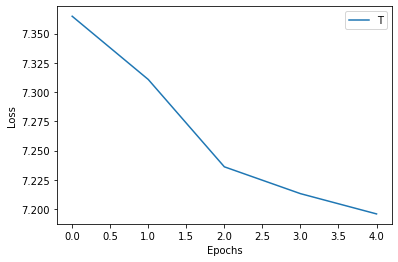

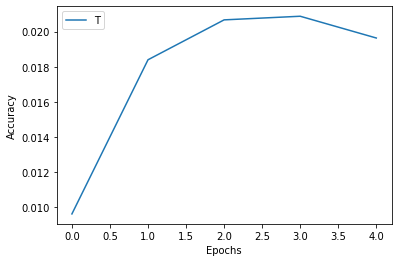

In [ ]:
def plot(model, val_bool = True):
  plt.plot(model.history['loss'], label='Train loss')
  if val_bool:
    plt.plot(model.history['val_loss'], label='Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  if val_bool:
    plt.legend(['Train_loss', 'Validation_loss'])
  else:
    plt.legend('Train_loss')
  plt.show()
  plt.plot(model.history['top_k_categorical_accuracy'], label='Train accuracy')
  if val_bool:
    plt.plot(model.history['val_top_k_categorical_accuracy'], label='Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  if val_bool:
    plt.legend(['Train_acc', 'Validation_acc'])
  else:
    plt.legend('Train_loss')
  plt.show()

plot(h, val_bool = False)

In [ ]:
#testing to make sure the model isn't getting rid of options to choose from!
hh= []
for i in range(len(test_predictors)):
  hh.append(np.count_nonzero(model.predict(test_predictors[[i]])))
for i in range(5):
  print(hh.count(i) / len(hh))



In [ ]:
token_list= train_itemidmap.loc[purchases_test[0][0:2]].tolist()
token_list = np.array(pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre'))
print(model.predict_proba(token_list).flatten())




[0.00060733 0.0006254  0.00061685 ... 0.00061197 0.00061148 0.00062113]


In [ ]:
train_itemidmap[purchases_test[0]]


4050549     259
4003156     162
4069470    1359
4051505    1380
3616580    1396
3551162     722
3551157      44
4081957     534
4103889     533
4049575     246
4076737     183
4084405      17
3957504    1439
4102273    1460
4085856      42
4168275    1274
3966285    1447
3754848     247
Name: ItemIdx, dtype: int64

In [ ]:
'''print(purchases_test[0])
print(generate_text(purchases_test[0][0:2], 1, max_sequence_len, train_itemidmap))
print(generate_text(purchases_test[0][1:3], 1, max_sequence_len, train_itemidmap))
print(generate_text(purchases_test[0][2:4], 1, max_sequence_len, train_itemidmap))
print(generate_text(purchases_test[0][3:5], 1, max_sequence_len, train_itemidmap))
print(generate_text(purchases_test[0][4:6], 1, max_sequence_len, train_itemidmap))
print(generate_text(purchases_test[0][5:7], 1, max_sequence_len, train_itemidmap))'''

#len(model.predict_proba(token_list).flatten().tolist())
token_list = np.array(pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre'))
model.predict_proba(token_list).flatten()


[4116034, 4096912, 4096912, 4086085, 4086085, 4267228, 3559889, 3559885]

In [ ]:
def visualize(tester_val, sub_seq_len):
  print("Visualizing...")
  total_seq = train_itemidmap.loc[purchases_test[tester_val]].tolist()
  print(total_seq)
  for i in range(len(total_seq) - sub_seq_len):
    token_list = total_seq[i:i+sub_seq_len]
    yoyo = token_list
    token_list = np.array(pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre'))
    print(yoyo, "-->", model.predict_proba(token_list).flatten().argsort()[-5:][::-1].tolist(), "Should ==", total_seq[i+sub_seq_len])
visualize(1, 4)


Visualizing...
[1350, 240, 1350, 213, 384, 439, 36, 1520, 337, 457, 1170, 1170]
[1350, 240, 1350, 213] --> [1084, 227, 396, 879, 77] Should == 384
[240, 1350, 213, 384] --> [227, 1049, 294, 137, 573] Should == 439
[1350, 213, 384, 439] --> [164, 573, 520, 387, 396] Should == 36
[213, 384, 439, 36] --> [573, 116, 1001, 43, 789] Should == 1520
[384, 439, 36, 1520] --> [902, 1338, 116, 1343, 1291] Should == 337
[439, 36, 1520, 337] --> [1338, 82, 1276, 1003, 547] Should == 457
[36, 1520, 337, 457] --> [426, 1685, 521, 595, 1279] Should == 1170
[1520, 337, 457, 1170] --> [526, 80, 2, 1111, 1663] Should == 1170


In [ ]:
def get_acc_seq_len(tester_val, sub_seq_len, extra_positives_len): #tester val for one
  acc = []
  print("Getting acc...")
  for i in tqdm(range(len(purchases_test))):
    total_seq = train_itemidmap.loc[purchases_test[i]].tolist()
    for i in range(len(total_seq) - sub_seq_len):
      possibles = []
      token_list = total_seq[i:i+sub_seq_len]
      next_purch = total_seq[i + sub_seq_len]
      #option 1 - next purchase is element of the sequence we're using to predict it --> accurate
      #or, just continue without counting accuracy - maybe better
      #if next_purch in token_list:
        #acc.append(True)
        #continue
      #option 2 - next purchase is any element in the sequence already, even those before our sequence we're using. 
      if next_purch in total_seq[:i + sub_seq_len]:
        acc.append(True)
        continue
      #get the top_k preds, but trim down to exclude those that have already been purchased
      #yoyo = token_list
      token_list = np.array(pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre'))
      predictions = model.predict_proba(token_list).flatten().argsort()[-50:][::-1].tolist() #get 100??? but narrow down after
      #if already purchased, don't recommend
      #for i in reversed(range(len(predictions))):
        #if predictions[i] in total_seq[:i+sub_seq_len]:
          #predictions.remove(predictions[i])
      predictions = predictions[0:5]
      #now, check if next_purch or a few extras are in the recommended list. if so, call it good.
      #might be risky - if i have three extras, and a few seqs in a row recommend that third item, i get three as good that aren't necessarily???
      possibles = total_seq[i+sub_seq_len:i+sub_seq_len+extra_positives_len]
      acc.append(any(check in possibles for check in predictions))
  return np.round(np.mean(acc), 4)
start = time.time()
print(get_acc_seq_len(1,5,5))
print(get_acc_seq_len(2,5,5))

#print("3 seq, 3 after:", get_acc_seq_len(3, 3, 3))
'''print("3 seq, 4 after:", get_acc_seq_len(3, 3, 4))
print("4 seq, 3 after:", get_acc_seq_len(3, 4, 3))
print("5 seq, 3 after:", get_acc_seq_len(3, 5, 3))
print("5 seq, 4 after:", get_acc_seq_len(3, 5, 4))'''



end = time.time()
print('time:', end-start, "Seconds")




  

  0%|          | 0/90 [00:00<?, ?it/s]

Getting acc...


100%|██████████| 90/90 [13:25<00:00,  8.95s/it]

0.0211
time: 805.2127313613892 Seconds


In [ ]:
test_acc = model.evaluate(test_predictors, test_label, verbose=0)[1]
print("Test Accuracy: ",np.round(test_acc,4))

Test Accuracy:  0.0163


In [ ]:
model.predict_proba(token_list).flatten().argsort()[-5:][::-1].tolist()

NameError: ignored

In [ ]:
def get_last_test():
  input_sequences = []
  token_list= []
  for line in purchases_test:
    token_list.append(train_itemidmap.loc[line].tolist()) #change jtv items to tokens
    input_sequences = np.array(pad_sequences(token_list, maxlen=max_sequence_len, padding='pre'))
  # create predictors and label
  predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
  label = ku.to_categorical(label, num_classes=total_words)
  return predictors, label


In [ ]:
test_predictors, test_label = get_last_test()
test_acc = model.evaluate(test_predictors, test_label, verbose=0)[1]
print("Test Accuracy: ",np.round(test_acc,4))

Test Accuracy:  0.0


In [ ]:
def revamped_acc():
  